# Project 3: Web APIs & Classification Part 2

## Importing data and libraries

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [2]:
pogo_df = pd.read_csv('pogo.csv')

In [3]:
pokken_df = pd.read_csv('pokken.csv')

## EDA, visualization & cleaning

### POGO

In [4]:
pogo_df = pogo_df[['selftext', 'title']]

In [5]:
pogo_df.isnull().value_counts()

selftext  title
False     False    975
dtype: int64

In [6]:
pogo_df["text"] = pogo_df["title"] +" "+ pogo_df["selftext"]

In [7]:
pogo_df = pogo_df[["text"]]

<span style="color:blue">Combining title and self-text</span>

In [8]:
len(pogo_df)

975

In [9]:
pogo_df['target'] = np.ones(975)

<span style="color:blue">Setting the target for all pogo columns to be 1</span>

In [10]:
pogo_df['length']=[len(row) for row in pogo_df['text']]

In [11]:
pogo_df.head()

,text,target,length
0,Slugma or Gulping? Research. I'm on step 5 of ...,1.0,236
1,gyarados should I evolve? I have a 93% magicar...,1.0,871
2,Is everybody I'm facing hackers? I re-started ...,1.0,508
3,Is Uxie not tradable? I'm trying to trade Uxie...,1.0,231
4,Is this a secret mission? I keep seeing a task...,1.0,131


In [12]:
pogo_df_len = pogo_df.sort_values(by='length', ascending=False)
pogo_df_len.head(10)

,text,target,length
860,Phone Buying Guide for Pokemon Go (2020) ## **...,1.0,29196
80,"An Open Letter to Niantic Dear Niantic,\n\nMy ...",1.0,3633
862,My speculation regarding future regional-exclu...,1.0,3441
474,My struggle with 5 players and Gyms After the ...,1.0,3198
527,QOL suggestion First and foremost I would like...,1.0,3097
710,Road to Legacy Level 40 Medal Calculator Howd...,1.0,2424
531,Me vs Mr Spoofer I started playing this game 1...,1.0,2395
851,Just have to get this off my chest Hey everyon...,1.0,2364
519,The catch cup is garbage. I am a relatively ne...,1.0,2274
787,Suggestion for Niantic: Add the Ability to Cha...,1.0,2164


In [13]:
pogo_df_len.tail(10)

,text,target,length
521,Chandelure Is Chandelure good in PvE or PvP?\n...,1.0,128
270,Is this luck or what? I just got a mesprit fro...,1.0,124
729,I hate this game I have had 3 legendary raids ...,1.0,124
971,My first Hundo! https://imgur.com/gallery/aznM...,1.0,123
593,Shiny Goldeen Does anyone know if the shiny ra...,1.0,122
296,I knew it! The Solrock from Pokemon Go looks l...,1.0,122
734,Post photos? I saw the newest mod post and I d...,1.0,122
384,Legendary raids Does anyone know when the lege...,1.0,118
166,Pokemon home I was wondering if you could have...,1.0,116
49,Help I don’t know why but I can’t find many if...,1.0,110


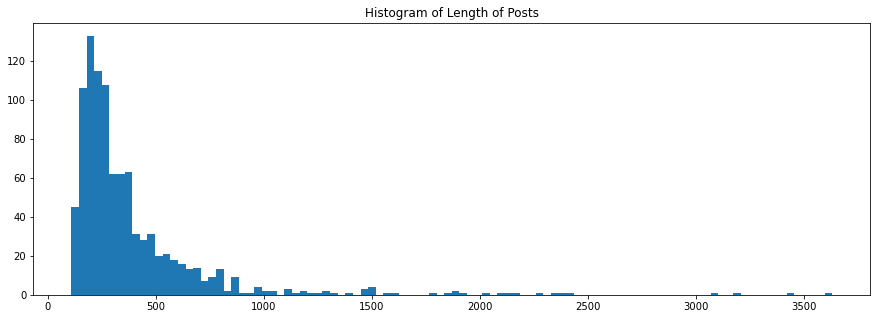

In [14]:
plt.figure(figsize=(15,5))
plt.title('Histogram of Length of Posts')
plt.hist(pogo_df_len['length'].loc[pogo_df_len['length']<5000], bins=100);

<span style="color:blue">Posts range from slightly over a hundred characters to 3000+ characters except for one outlier with almost 30000 characters. It was decided to keep the outlier since there is only one and its contents may be helpful to building the classification model.</span>

In [15]:
pogo_giant_text = []
for row in pogo_df['text']:
    pogo_giant_text.append(row.lower() + ' ')

In [16]:
tokenizer = RegexpTokenizer(r'\w+')
pogo_tokens = tokenizer.tokenize(' '.join(pogo_giant_text))

In [17]:
pogo_tokens = [w for w in pogo_tokens if w not in stopwords.words('english')]

In [18]:
pogo_tokens_df = pd.DataFrame(pogo_tokens)
pogo_value_counts_df = pd.DataFrame(pogo_tokens_df.value_counts().rename_axis('word').reset_index(name='counts'))

In [19]:
pogo_value_counts_df.head()

,word,counts
0,get,474
1,pokemon,430
2,one,340
3,go,311
4,pokémon,307


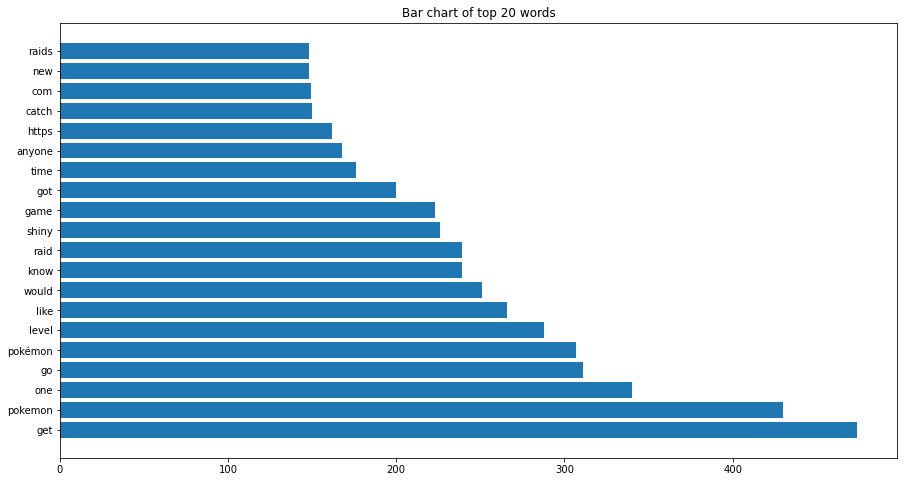

In [20]:
plt.figure(figsize=(15,8))
plt.title('Bar chart of top 20 words')
plt.barh(pogo_value_counts_df['word'][:20], pogo_value_counts_df['counts'][:20]);

<span style="color:blue">Words to remove before modeling: 'pokémon', 'pokemon', 'go', 'https' \& 'com'</span>

In [21]:
def plot_cloud(wordcloud):
    
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud) 
    plt.axis("off");

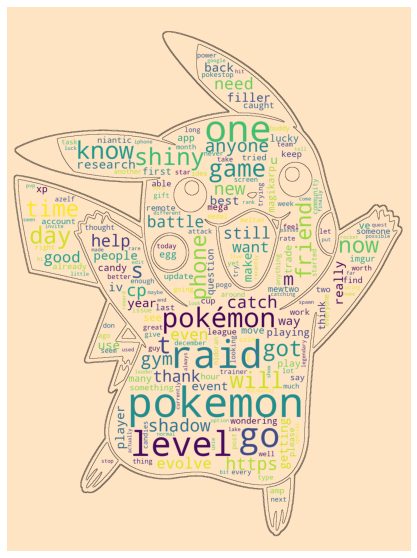

In [22]:
mask = np.array(Image.open('image2.png'))
wordcloud = WordCloud(contour_width = 0.1, width = 3000, height = 2000, random_state=1, background_color='bisque', colormap='viridis', collocations=False, stopwords = STOPWORDS, mask = mask).generate(' '.join(pogo_giant_text))

plot_cloud(wordcloud)

<span style="color:blue">Wordcloud of popular words from the Pogo subreddit</span>

### Pokken

In [23]:
pokken_df = pokken_df[['selftext', 'title']]

In [24]:
pokken_df.isnull().value_counts()

selftext  title
True      False    498
False     False    477
dtype: int64

In [25]:
pokken_df[['selftext']] = pokken_df[['selftext']].fillna(".")

<span style="color:blue">Filling in null values in selftext to allow for combining of the column with the title. A "." is used for ease of removal subsequently using the Regex Tokenizer</span>

In [26]:
pokken_df["text"] = pokken_df["title"] +" "+ pokken_df["selftext"]

In [27]:
pokken_df = pokken_df[["text"]]

In [28]:
len(pokken_df)

975

In [29]:
pokken_df['target'] = np.zeros(975)

In [30]:
pokken_df['length']=[len(row) for row in pokken_df['text']]

In [31]:
pokken_df.head()

,text,target,length
0,The 21st Trainer's School character guide focu...,0.0,90
1,Just a very anime styled clip .,0.0,31
2,Is There Anything I Should Learn New? I’m Supp...,0.0,365
3,Facing Off Against the Greatest Scizor! (Jukem...,0.0,56
4,"Trying to get a friend into the game, I put to...",0.0,3980


In [32]:
pokken_df_len = pokken_df.sort_values(by='length', ascending=False)
pokken_df_len.head(10)

,text,target,length
253,"Pokken 2 The Pokemon Presents is tomorrow, and...",0.0,17239
777,Swampert Kit Concept Before this starts I woul...,0.0,16121
973,Venusaur Kit Concept Venusaur \nThe Seed Pokem...,0.0,13095
280,Pokkén Community News Update 5/8/2020 - 5/19/2...,0.0,8532
35,New Fighter Idea: Deoxys # Intro\n\nSo I know ...,0.0,6480
731,Honest opinion from two newer players First of...,0.0,4415
165,A number of professional players from Japan ha...,0.0,4308
4,"Trying to get a friend into the game, I put to...",0.0,3980
760,"Beating Spam (part 1?) Hi, I'm a Chandelure an...",0.0,3283
289,Pokken community discord directory v2 Undoubte...,0.0,3232


In [33]:
pokken_df_len.tail(10)

,text,target,length
860,Player Profile: Kamon .,0.0,23
368,Best support set? .,0.0,19
81,H I T B O X E S .,0.0,17
553,tfw u get mixed .,0.0,17
400,Help dlc issue .,0.0,16
956,Poor driver... .,0.0,16
753,Rate my brain .,0.0,15
837,Sceptile X+A .,0.0,14
332,Tough cookie .,0.0,14
335,Good news! .,0.0,12


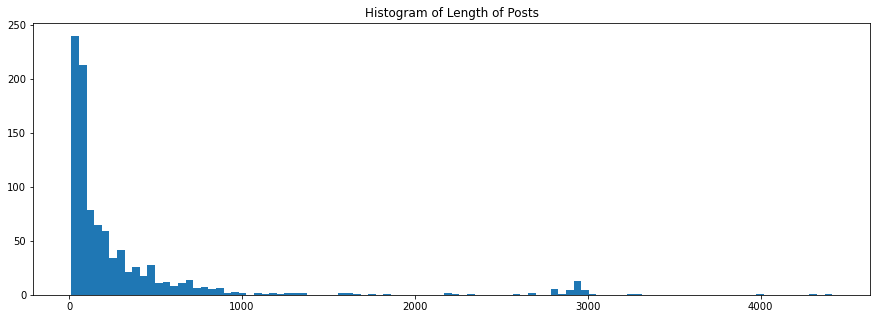

In [34]:
plt.figure(figsize=(15,5))
plt.title('Histogram of Length of Posts')
plt.hist(pokken_df_len['length'].loc[pokken_df_len['length']<5000], bins=100);

<span style="color:blue">Posts range from slightly over just 10 characters to about 4000. Five outliers that are significantly longer than 4000 characters. A significant number of posts are observed to be extremely short. These are likely the posts that only had a title but no selftext. It was decided to keep the outliers since there are only 5 and they may be helpful to building the classification model</span>

In [35]:
pokken_giant_text = []
for row in pokken_df['text']:
    pokken_giant_text.append(row.lower() + ' ')

In [36]:
pokken_tokens = tokenizer.tokenize(' '.join(pokken_giant_text))

In [37]:
pokken_tokens = [w for w in pokken_tokens if w not in set(stopwords.words('english'))]

In [38]:
pokken_tokens_df = pd.DataFrame(pokken_tokens)
pokken_value_counts_df = pd.DataFrame(pokken_tokens_df.value_counts().rename_axis('word').reset_index(name='counts'))

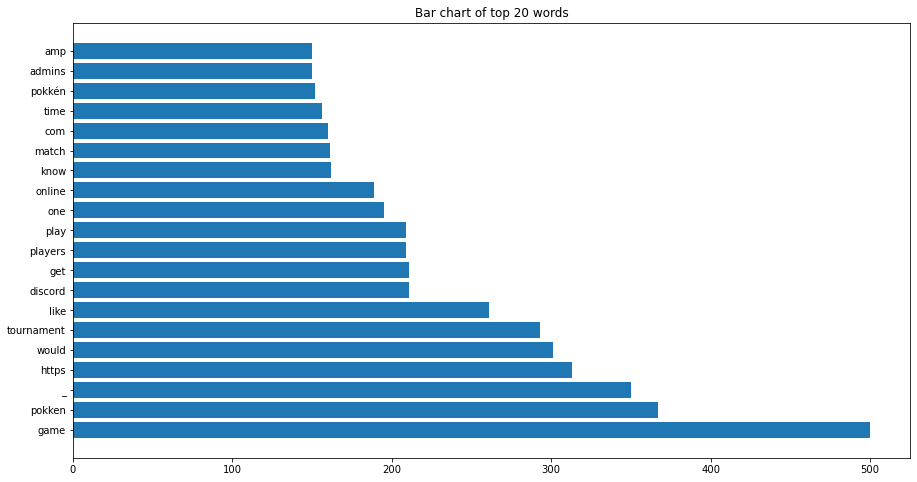

In [39]:
plt.figure(figsize=(15,8))
plt.title('Bar chart of top 20 words')
plt.barh(pokken_value_counts_df['word'][:20], pokken_value_counts_df['counts'][:20]);

<span style="color:blue">Additional words to remove before modeling: 'pokkén', 'pokken' & '_'</span>

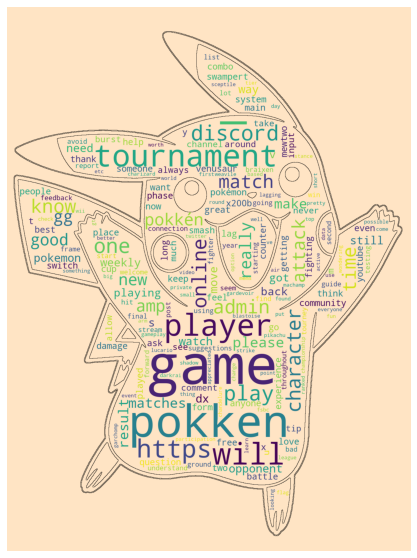

In [40]:
mask = np.array(Image.open('image2.png'))
wordcloud2 = WordCloud(contour_width = 0.1, width = 3000, height = 2000, random_state=1, background_color='bisque', colormap='viridis', collocations=False, stopwords = STOPWORDS, mask = mask).generate(' '.join(pokken_giant_text))

plot_cloud(wordcloud2)

<span style="color:blue">Wordcloud of popular words from the Pokken subreddit</span>

In [41]:
to_remove = {'pokémon', 'pokemon', 'go', 'https', 'com', 'pokkén', 'pokken', '_'}

<span style="color:blue">'https', 'com' and '_' are to be removed since they do not add any value to the classification. The other words are to be removed since they are part of the title of the sub reddits</span>

### Combining and cleaning the two DataFrames

In [42]:
combined_df = pd.concat([pogo_df, pokken_df])

In [43]:
combined_df.shape

(1950, 3)

In [44]:
combined_df.head()

,text,target,length
0,Slugma or Gulping? Research. I'm on step 5 of ...,1.0,236
1,gyarados should I evolve? I have a 93% magicar...,1.0,871
2,Is everybody I'm facing hackers? I re-started ...,1.0,508
3,Is Uxie not tradable? I'm trying to trade Uxie...,1.0,231
4,Is this a secret mission? I keep seeing a task...,1.0,131


In [45]:
def post_cleaning(post):
    
    #Remove HTML.
    no_html = BeautifulSoup(post).get_text()
    
    #Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", no_html)
    
    #Convert to lower case & split into individual words.
    lower_words = letters_only.lower().split()
    
    #Set of words to remove
    stops = (set(stopwords.words('english')))|to_remove
    
    #Remove selected words.
    words_stopped = [w for w in lower_words if w not in stops]
    
    #Applying lemmatization to the words
    lemmatizer = WordNetLemmatizer()
    words_cleaned = [lemmatizer.lemmatize(word) for word in words_stopped]
    
    #Join the words back into one string and return
    return(" ".join(words_cleaned))

In [46]:
combined_df['text'] = [post_cleaning(post) for post in combined_df['text']]

<span style="color:blue">Apply cleaning function to all posts</span>

In [47]:
combined_df.head()

,text,target,length
0,slugma gulping research step let meltan requir...,1.0,236
1,gyarados evolve magicarp want evolve want till...,1.0,871
2,everybody facing hacker started playing day ag...,1.0,508
3,uxie tradable trying trade uxie let select eve...,1.0,231
4,secret mission keep seeing task bar catching s...,1.0,131


In [48]:
sum(combined_df.duplicated(subset='text', keep='first'))

61

In [49]:
combined_df.drop_duplicates(subset='text', keep='first', inplace=True)

In [50]:
combined_df.tail()

,text,target,length
970,fsbc deep blue monarch cup need know,0.0,51
971,training group hello everyone leader coming tr...,0.0,595
972,tournament result july defend north catch inside,0.0,85
973,venusaur kit concept venusaur seed playstyle v...,0.0,13095
974,metal claw special mid mid high attack meaning...,0.0,135


<span style="color:blue">Checking for and dropping duplicates</span>

In [51]:
combined_df.shape

(1889, 3)

In [52]:
combined_df.reset_index(inplace=True) 

In [53]:
combined_df.tail()

,index,text,target,length
1884,970,fsbc deep blue monarch cup need know,0.0,51
1885,971,training group hello everyone leader coming tr...,0.0,595
1886,972,tournament result july defend north catch inside,0.0,85
1887,973,venusaur kit concept venusaur seed playstyle v...,0.0,13095
1888,974,metal claw special mid mid high attack meaning...,0.0,135


<span style="color:blue">Reset index so all posts have a unique index value</span>

## Preprocessing, modeling and evaluation

### Split data into train and test sets

In [60]:
X_train, X_test, y_train, y_test = train_test_split(combined_df['text'],
                                                    combined_df['target'],
                                                    test_size=0.2,
                                                    stratify=combined_df['target'],
                                                    random_state = 42)

In [61]:
y_test.value_counts(normalize=True)

1.0    0.515873
0.0    0.484127
Name: target, dtype: float64

<span style="color:blue">Baseline accuracy is 51.6%</span>

### Tfidf Vectorizer and Naive Bayes classifier

#### Creating pipeline

In [124]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [137]:
pipe_params = {
    'tvec__max_features' : [1000, 2000, 3000],
    'tvec__min_df' : [2, 3, 4],
    'tvec__ngram_range' : [(1,1), (1,2)]
}

<span style="color:blue">Create a pipeline using Tfidf Vectorizer and MultinomialNB to test for various params.</span>

#### Initializing and running gridsearch

In [138]:
gs = GridSearchCV(pipe,
                  param_grid = pipe_params,
                  cv=5)

In [139]:
gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [1000, 2000, 3000],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [140]:
gs.best_params_

{'tvec__max_features': 2000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}

#### Checking on the performance of the gridsearch

In [141]:
gs.best_score_

0.9589644394903066

In [142]:
gs.score(X_train, y_train)

0.9794837855724685

In [143]:
gs.score(X_test, y_test)

0.9603174603174603

<span style="color:blue">Getting best params and scoring on both train and test data. High scores indicate that classifier was largely successful in distinguishing which posts belong to each sub-reddit. Only a slight decrease in score was observed between the train and test data indicating minimal over-fitting</span>

### Count Vectorizer and Naive Bayes classifier

#### Creating pipeline

In [153]:
pipe2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [162]:
pipe_params2 = {
    'cvec__max_features' : [2000, 3000, 4000],
    'cvec__ngram_range' : [(1,1), (1,2)]
}

<span style="color:blue">Create a pipeline using Count Vectorizer and MultinomialNB to test for various params.</span>

#### Initializing and running gridsearch

In [163]:
gs2 = GridSearchCV(pipe2,
                  param_grid = pipe_params2,
                  cv=5)

In [164]:
gs2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_features': [2000, 3000, 4000],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [165]:
gs2.best_params_

{'cvec__max_features': 3000, 'cvec__ngram_range': (1, 1)}

#### Checking on the performance of the gridsearch

In [166]:
gs2.best_score_

0.9576530500732193

In [167]:
gs2.score(X_train, y_train)

0.9788219722038385

In [168]:
gs2.score(X_test, y_test)

0.955026455026455

<span style="color:blue">Getting best params and scoring on both train and test data. High scores indicate that classifier was largely successful in distinguishing which posts belong to each sub-reddit. It was observed that Tfidf Vectorizer has a marginally better performance than Count Vectorizer</span>

### Tfidf Vectorizer and Support Vector Classification

#### Creating 1st pipeline

In [237]:
pipe3 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
])

In [238]:
pipe_params3 = {
    'svc__C' : [0.4, 0.5, 0.6],
    'svc__kernel' : ['poly', 'rbf', 'sigmoid'],
    'svc__max_iter' : [1000, 2000, 3000],
    'svc__random_state' : [42],
    'tvec__min_df' : [1, 2, 3],
    'tvec__ngram_range' : [(1,1), (1,2), (1,3)]
}

<span style="color:blue">Create a pipeline using Tfidf Vectorizer and SVC to test for various params.</span>

#### Initializing and running 1st gridsearch

In [239]:
gs3 = GridSearchCV(pipe3,
                  param_grid = pipe_params3,
                  cv=5)

In [243]:
gs3.fit(X_train,y_train)

C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jonat\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.4, 0.5, 0.6],
                         'svc__kernel': ['poly', 'rbf', 'sigmoid'],
                         'svc__max_iter': [1000, 2000, 3000],
                         'svc__random_state': [42], 'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [244]:
gs3.best_params_

{'svc__C': 0.5,
 'svc__kernel': 'sigmoid',
 'svc__max_iter': 1000,
 'svc__random_state': 42,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

<span style="color:blue">When max_iters = 1000, solver terminated early. Retry gridsearch varying only max_iters for SVC</span>

#### Creating 2nd pipeline varying only max_iters for SVC

In [223]:
pipe4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
])

In [232]:
pipe_params4 = {
    'svc__C' : [0.5],
    'svc__kernel' : ['sigmoid'],
    'svc__max_iter' : [1100, 1200],
    'svc__random_state' : [42],
    'tvec__min_df' : [2],
    'tvec__ngram_range' : [(1,2)]
}

#### Initializing and running 2nd gridsearch

In [233]:
gs4 = GridSearchCV(pipe4,
                  param_grid = pipe_params4,
                  cv=5)

In [234]:
gs4.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.5], 'svc__kernel': ['sigmoid'],
                         'svc__max_iter': [1100, 1200],
                         'svc__random_state': [42], 'tvec__min_df': [2],
                         'tvec__ngram_range': [(1, 2)]})

In [235]:
gs4.best_params_

{'svc__C': 0.5,
 'svc__kernel': 'sigmoid',
 'svc__max_iter': 1100,
 'svc__random_state': 42,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

#### Checking on the performance of the gridsearch

In [240]:
gs4.best_score_

0.9669092737088277

In [241]:
gs4.score(X_train, y_train)

0.9907346128391793

In [242]:
gs4.score(X_test, y_test)

0.9761904761904762

<span style="color:blue">Getting best params and scoring on both train and test data. High scores indicate that classifier was largely successful in distinguishing which posts belong to each sub-reddit. It was observed that SVC performed marginally better as compared to Naive Bayes</span>

### Getting the confusion matrix for the best classifier

In [246]:
y_pred = gs4.predict(X_test)

In [247]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [248]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 178
False Positives: 5
False Negatives: 4
True Positives: 191


<span style="color:blue">True Negatives are posts that are correctly classified to the Pokken sub-reddit.<br>
False Positives are posts that belong to the Pokken thread but were wrongly classified under the Pokemon GO sub-reddit.<br>
False Negatives are posts that belong to the Pokemon Go thread but were wrongly classified under the Pokken sub-reddit.<br>
True Positives are posts that are correctly classified to the Pokemon Go sub-reddit.</span>

### Examination of misclassified posts 

In [252]:
test_df = pd.DataFrame(X_test)

In [256]:
test_df['target'] = y_test

In [258]:
test_df['preds'] = y_pred

In [259]:
test_df.head()

,text,target,preds
260,focus building good raid team raid challenge w...,1.0,1.0
138,azelf event every legendary five star raid nea...,1.0,1.0
1311,ausbros wondering worth picking want pick find...,0.0,0.0
622,special research recently got back game playin...,1.0,1.0
521,nidoran limited research question kind expecti...,1.0,1.0


In [261]:
test_df.shape

(378, 3)

In [264]:
test_df.loc[test_df['target']!=test_df['preds']]

,text,target,preds
542,returning player tip used play lot back level ...,1.0,0.0
1823,getting frustrated keep running dojos weavile ...,0.0,1.0
1741,wanna know everybody top three character would...,0.0,1.0
672,fast charged tm determine good move like ex ap...,1.0,0.0
580,ar mapping unwanted way play found single play...,1.0,0.0
1635,blacklist people dx clue keep getting two peop...,0.0,1.0
1350,new wanna get back loved game ever since saw l...,0.0,1.0
319,playing vpn get banned know question might ove...,1.0,0.0
1363,get twitter realtimmen status twitter realtimm...,0.0,1.0


In [267]:
test_df['text'][319]

'playing vpn get banned know question might overused could really use help problem month game connect home wifi connects mobile data tried resetting wifi several time never fixed problem downloaded turbo vpn saw game connects wifi long vpn live philippine vpn set usa safe play way'

In [268]:
test_df['text'][1363]

'get twitter realtimmen status twitter realtimmen status'

<span style="color:blue">Randomly selecting two of the mismatches, it is likely that they got mis-classified due to the general nature of the posts.<br><br>The first post [319] is from a redditer that had a VPN or connection issue which could happen to pretty much any gamer. Since this post is rather general in nature, it is likely that it contained words more strongly associated with the wrong sub-reddit thus causing the misclassification.<br><br>
The second post [1363] might have had some words removed by the cleaning function implemented earlier. The remaining words do not provide much context. A quick look shows that the unique words are 'get', 'twitter', 'realtimmen' and 'status'. With the exception of 'realtimmen' which doesn't make sense, the other words seem rather general and may thus have caused the misclassification since they could be more strongly associated with the wrong sub-reddit.</span>

## Conclusion

On the whole, it can be said that this classifier has shown to be largely successful in classifying posts to the correct sub-reddit with a score of 99.1% on train data and 97.6% on test data as compared to the baseline score of 51.6%. The extremely high scores indicate that the contents of the two sub-reddits have features that are easily distinguishable from one another. While both games are based on Pokemon, it is likely that the different natures of the games contributed to the posts being easily distinguishable.

Since the classifier is largely successful in distinguishing posts from the two sub-reddits, it has fulfilled its purpose of being the first step in helping game developers separate posts for further analysis to provide insights that can aid game updates and the development of future games. Further analysis of the classified posts for improvements on game updates and development are not within the scope of this project.

## Recommendation

The classifier model built may be useful to classify posts from other forums outside of reddit that may be talking about these games as well. Posts and user feedback from other forums that can be found online may provide additional insights. One limitation of this model is that it is a binary classifier. A new model that is able to classify posts into the various Pokemon game titles across the various generations and platforms would be a lot more useful as it can be used in forums such as the main Pokemon sub-reddit: https://www.reddit.com/r/pokemon/. For the purpose of this project, words associated with the title of the sub-reddits were removed. In an actual classifier model, it would be better to keep such words since they would be the clearest identifiers possible.